In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import isnan, when, count, col
#from pyspark.ml.regression import LabeledPoint
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import NaiveBayesModel
from pyspark.ml.linalg import Vector, SparseVector, DenseVector, Matrices
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("BetsExploring").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=BetsExploring>

In [3]:
betsHouses = ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'SB', 'SJ', 'VC', 'WH']
quotaTypes = ['H','D','A']
accuracyList = []

In [4]:
# Selecting fields included in dataframe to use as features

def calcBetsHousesCols(df, betsHouses):
    betsHousesCols = []
    betsHousesOk = []
    for betsHouse in betsHouses:
        col = betsHouse + 'H'
        if col in df.columns:
            betsHousesOk.append(betsHouse)
            betsHousesCols.append(betsHouse + 'H')
            betsHousesCols.append(betsHouse + 'D')
            betsHousesCols.append(betsHouse + 'A')

    print ("Potential bets houses:", betsHouses)
    print ("Bets houses selected :" , betsHousesOk)
    print ("Bets houses columns  :", betsHousesCols)
    
    return betsHousesCols

In [5]:
# Cleaning nulls in dataframe, mixing deletion of columns and rows
# Columns with less than 'percDropping' not null rows will be deleted
# Rows with nulls aftes deleting columns will be deleted

def cleanNulls(df, percDropping):
    print ("Cleaning nulls:")
    totalrows = df.count()
    notnullrows = df.dropna().count()
    dropCols = []
    print ("Total rows:", totalrows)
    print ("Not null rows: ", notnullrows)
    print ("Percentage for dropping column: ", percDropping, "%")

    print ("\nNot null rows before cleaning:")
    dfok = df
    for col in df.columns:

        percOk = round((df.select(col).dropna().count() / totalrows) * 100, 2)
        print (col, "\t", df.select(col).dropna().count(), "\t(", percOk, "%)")

        # Dropping columnss with a lot of nulls
        if percOk < percDropping:
            dropCols.append(col)
            dfok = dfok.drop(col)
    #        print ("\tColumn dropped")

    # Dropping row with nulls
    dfok = dfok.dropna()
    percOk = round((dfok.count() / totalrows) * 100 , 2)
    print ("\nDropped columns:", dropCols)
    print ("Not null rows after cleaning: " , dfok.count(), "\t(", percOk, "%)")
    print ("Final columns:", dfok.columns)
    
    return dfok

In [6]:
# Converting text result to numeric result

def resultToNumeric(df):
    dfok = df.withColumn("Label", when(df['FTR']=='H',0)
                             .when(df['FTR']=='D',1)
                             .when(df['FTR']=='A',2).cast("double"))
    dfok.show(3)
                      
    return dfok

In [7]:
# Create Dataframe with label and features 

def createLabelAndFeatures(df, betsHousesCols):
    vectorAssembler = VectorAssembler(
        inputCols = betsHousesCols, 
        outputCol = 'features')

    vec_df = vectorAssembler.transform(df)

    vec_df = vec_df.withColumn("label", df["Label"])

    vec_df = vec_df.select(['features', 'label'])
    vec_df.show(5, False)
    vec_df.printSchema()
    
    return vec_df

In [8]:
# Defining, Training and Avaluating Naive Bayes Model

def calcNaiveBayesModel(df, paramCols):
    
    # Converting result to numeric
    print ("\n  - Converting result to numeric")
    df = resultToNumeric(df)

    # Creating vector with label and features for training
    print ("\n  - Creating vector with label and features for training")
    print ("paramCols:", paramCols)
    vectrain = createLabelAndFeatures(df, paramCols)

    # Training model
    print ("\n  - Training model")
    nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
    model = nb.fit(vectrain)
    print("Pi   :", model.pi)
    print("Theta:", model.theta)

    # Calculating auto-prediction to avaluate model
    print ("\n  - Calculating auto-prediction to avaluate model")
    predict_train = model.transform(vectrain)
    predict_train.show(5, False)

    # Evaluating model
    print ("\n  - Evaluating model")
    nb_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",metricName="accuracy")
    accuracy = nb_evaluator.evaluate(predict_train)
    print ("Accuracy: ", round(accuracy * 100, 2), "%")
    
    return (model, accuracy)

In [9]:
# Calculating predictions with test dataset
def calcPrediction (model, df, paramCols):
    
    # Converting result to numeric
    print ("\n  - Converting result to numeric")
    df = resultToNumeric(df)

    # Creating vector with label and features for training
    print ("  - Creating vector with label and features for training")
    vectest = createLabelAndFeatures(df, paramCols)

    # Calculating prediction
    print ("  - Calculating prediction")
    predict = model.transform(vectest)
    print(predict.count())
    predict.show(5, False)

    # Evaluating test
    print ("  - Evaluating model")
    nb_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",metricName="accuracy")
    accuracy = nb_evaluator.evaluate(predict)
    print ("Accuracy: ", round(accuracy * 100, 2), "%")
    
    return (predict, accuracy)

In [10]:
# Calculating Naive Bayes Model and Prediction

def calcModelAndPrediction(df):
    
    # Cleaning nulls in columns and rows
    print ("\n* Cleaning nulls in columns and rows")
    dfok = cleanNulls(df, 80)

    # Calculating Bets Houses Cols
    print ("\n  - Calculating Bets Houses Cols")
    betsHousesCols =  calcBetsHousesCols(dfok, betsHouses)

    # Spliting training and testing datasets
    print ("\n* Spliting training and testing datasets")
    dftrain, dftest = dfok.randomSplit([0.8, 0.2], seed=1)
    print("  Train dataset:", dftrain.count(), "rows")
    print("  Test dataset: ", dftest.count(), "rows")

    # Defining, Training and Avaluating Naive Bayes Model
    print ("\n* Defining, Training and Avaluating Naive Bayes Model")
    (model, modelAccuracy) = calcNaiveBayesModel(dftrain, betsHousesCols)

    # Calculating predictions with test dataset
    print ("\n* Calculating predictions with test dataset")
    (predict, predictAccuracy) = calcPrediction(model, dftest, betsHousesCols)

    return (modelAccuracy, predictAccuracy)

In [11]:
url = "../Data/Processed/main_competitions_recent.csv"
# Open Dataset file
print ("* Opening dataset file")
df = spark.read.csv(path = url, header = True, inferSchema = True)
print ("Rows   :", df.count())
print ("First row:")
print(df.take(1))
df.printSchema()


* Opening dataset file
Rows   : 11374
First row:
[Row(Country='Belgium', Competition='JupilerLeague', Season='2017-2018', Div='B1', Date=datetime.datetime(2017, 7, 28, 0, 0), HomeTeam='Antwerp', AwayTeam='Anderlecht', FTR='D', B365H=5.75, B365D=3.8, B365A=1.6, BWH=5.0, BWD=4.0, BWA=1.67, IWH=4.7, IWD=3.6, IWA=1.7, LBH=5.2, LBD=3.7, LBA=1.61, VCH=5.5, VCD=3.9, VCA=1.62, WHH=4.75, WHD=3.75, WHA=1.67, Divergence=11.65048543689322)]
root
 |-- Country: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Div: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTR: string (nullable = true)
 |-- B365H: double (nullable = true)
 |-- B365D: double (nullable = true)
 |-- B365A: double (nullable = true)
 |-- BWH: double (nullable = true)
 |-- BWD: double (nullable = true)
 |-- BWA: double (nullable = true)
 |-- IWH: double (nullable = true)
 |

In [32]:
labelList = []
modelList = []
predictList = []

In [36]:
for country in countryList:
    dfSpain = df.filter(df["Country"]==country)
    print ("Rows   :", dfSpain.count())
    print ("First row:")
    print(dfSpain.take(1))
    dfSpain.printSchema()

    (modelAccuracy, predictAccuracy) = calcModelAndPrediction(dfSpain)

    labelList.append(country)
    modelList.append(modelAccuracy)
    predictList.append(predictAccuracy)

    print ("\n* Naive Bayes model of ", country)
    print ("Model accuracy     : ", round(modelAccuracy * 100, 2), "%")
    print ("Prediction accuracy: ", round(predictAccuracy * 100, 2), "%")

Rows   : 450
First row:
[Row(Country='Turkey', Competition='FutbolLigi1', Season='2017-2018', Div='T1', Date=datetime.datetime(2017, 11, 8, 0, 0), HomeTeam='Buyuksehyr', AwayTeam='Bursaspor', FTR='H', B365H=1.36, B365D=4.75, B365A=8.5, BWH=1.4, BWD=4.25, BWA=7.75, IWH=1.35, IWD=4.8, IWA=7.6, LBH=1.33, LBD=4.75, LBA=8.5, VCH=1.33, VCD=5.0, VCA=9.0, WHH=1.36, WHD=4.5, WHA=7.5, Divergence=10.542476970317294)]
root
 |-- Country: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Div: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTR: string (nullable = true)
 |-- B365H: double (nullable = true)
 |-- B365D: double (nullable = true)
 |-- B365A: double (nullable = true)
 |-- BWH: double (nullable = true)
 |-- BWD: double (nullable = true)
 |-- BWA: double (nullable = true)
 |-- IWH: double (nullable = true)
 |-- IWD: double (nullabl

+-------------------------------------------------------------------+-----+
|features                                                           |label|
+-------------------------------------------------------------------+-----+
|[1.8,3.75,4.2,1.87,3.4,4.0,2.1,3.3,3.3,1.83,3.7,4.1,1.85,3.5,3.8]  |0.0  |
|[2.04,3.25,3.75,2.05,3.2,3.6,2.2,3.3,3.1,2.1,3.4,3.5,2.05,3.25,3.4]|2.0  |
|[4.33,4.2,1.66,4.6,3.9,1.65,4.7,3.6,1.7,4.5,4.1,1.7,4.4,3.8,1.67]  |2.0  |
|[3.5,3.39,2.04,3.5,3.4,2.0,3.3,3.3,2.1,3.4,3.5,2.1,3.25,3.4,2.05]  |2.0  |
|[2.88,3.2,2.5,2.8,3.25,2.4,2.85,3.3,2.35,2.8,3.4,2.45,2.7,3.4,2.38]|0.0  |
+-------------------------------------------------------------------+-----+
only showing top 5 rows

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

  - Calculating prediction
82
+-------------------------------------------------------------------+-----+-------------------------------------------------------------+-----------------------------------------

+--------------------------------------------------------------------+-----+-------------------------------------------------------------+--------------------------------------------------------------+----------+
|features                                                            |label|rawPrediction                                                |probability                                                   |prediction|
+--------------------------------------------------------------------+-----+-------------------------------------------------------------+--------------------------------------------------------------+----------+
|[3.8,3.5,2.0,3.6,3.4,2.0,3.5,3.4,2.1,3.7,3.6,2.05,3.4,3.6,2.05]     |2.0  |[-128.69329402656354,-127.82319810478526,-124.91580572175691]|[0.021234457946738564,0.05068962014708975,0.9280759219061716] |2.0       |
|[3.6,3.5,2.05,3.5,3.5,2.0,3.8,3.4,2.0,3.5,3.6,2.1,3.5,3.6,2.0]      |0.0  |[-128.5089103890654,-127.64734368953438,-124.77252219784434] |[0.0220686

B365H 	 1109 	( 100.0 %)
B365D 	 1109 	( 100.0 %)
B365A 	 1109 	( 100.0 %)
BWH 	 1109 	( 100.0 %)
BWD 	 1109 	( 100.0 %)
BWA 	 1109 	( 100.0 %)
IWH 	 1108 	( 99.91 %)
IWD 	 1108 	( 99.91 %)
IWA 	 1108 	( 99.91 %)
LBH 	 757 	( 68.26 %)
LBD 	 757 	( 68.26 %)
LBA 	 757 	( 68.26 %)
VCH 	 1109 	( 100.0 %)
VCD 	 1109 	( 100.0 %)
VCA 	 1109 	( 100.0 %)
WHH 	 1109 	( 100.0 %)
WHD 	 1109 	( 100.0 %)
WHA 	 1109 	( 100.0 %)
Divergence 	 1109 	( 100.0 %)

Dropped columns: ['LBH', 'LBD', 'LBA']
Not null rows after cleaning:  1108 	( 99.91 %)
Final columns: ['Country', 'Competition', 'Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA', 'Divergence']

  - Calculating Bets Houses Cols
Potential bets houses: ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'SB', 'SJ', 'VC', 'WH']
Bets houses selected : ['B365', 'BW', 'IW', 'VC', 'WH']
Bets houses columns  : ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', '

229
+----------------------------------------------------------------------+-----+-------------------------------------------------------------+------------------------------------------------------------+----------+
|features                                                              |label|rawPrediction                                                |probability                                                 |prediction|
+----------------------------------------------------------------------+-----+-------------------------------------------------------------+------------------------------------------------------------+----------+
|[2.62,3.2,2.7,2.6,3.2,2.6,2.5,3.25,2.7,2.6,3.2,2.8,2.5,3.25,2.6]      |1.0  |[-117.8546831057146,-116.22241088653207,-115.65194655400624] |[0.06594031316817887,0.33731668463237896,0.5967430021994421]|2.0       |
|[2.45,3.0,3.1,2.4,3.1,2.9,2.4,3.0,2.9,2.45,3.1,3.1,2.38,3.1,2.88]     |1.0  |[-116.74365094054143,-115.70117949999938,-115.52491482229972]|[0.1

+--------------------------------------------------------------------------+-----+-------------------------------------------------------------+-----------------------------------------------------------------+----------+
|features                                                                  |label|rawPrediction                                                |probability                                                      |prediction|
+--------------------------------------------------------------------------+-----+-------------------------------------------------------------+-----------------------------------------------------------------+----------+
|[1.64,3.29,6.0,1.72,3.4,5.75,1.65,3.4,5.75,1.65,3.4,5.75,1.75,3.2,4.8]    |0.0  |[-139.2522235168751,-142.87223878377884,-149.4880846882463]  |[0.973882299283316,0.026082776357335843,3.492435934808329E-5]    |0.0       |
|[1.14,7.5,17.0,1.15,7.75,20.0,1.15,6.75,16.75,1.13,7.5,18.0,1.12,7.0,17.0]|0.0  |[-317.5883401127466,-345.27558

FTR 	 392 	( 100.0 %)
B365H 	 392 	( 100.0 %)
B365D 	 392 	( 100.0 %)
B365A 	 392 	( 100.0 %)
BWH 	 392 	( 100.0 %)
BWD 	 392 	( 100.0 %)
BWA 	 392 	( 100.0 %)
IWH 	 392 	( 100.0 %)
IWD 	 392 	( 100.0 %)
IWA 	 392 	( 100.0 %)
LBH 	 240 	( 61.22 %)
LBD 	 240 	( 61.22 %)
LBA 	 240 	( 61.22 %)
VCH 	 392 	( 100.0 %)
VCD 	 392 	( 100.0 %)
VCA 	 392 	( 100.0 %)
WHH 	 392 	( 100.0 %)
WHD 	 392 	( 100.0 %)
WHA 	 392 	( 100.0 %)
Divergence 	 392 	( 100.0 %)

Dropped columns: ['LBH', 'LBD', 'LBA']
Not null rows after cleaning:  392 	( 100.0 %)
Final columns: ['Country', 'Competition', 'Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA', 'Divergence']

  - Calculating Bets Houses Cols
Potential bets houses: ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'SB', 'SJ', 'VC', 'WH']
Bets houses selected : ['B365', 'BW', 'IW', 'VC', 'WH']
Bets houses columns  : ['B365H', 'B365D', 'B365A', 'BWH', 'BW

77
+--------------------------------------------------------------------+-----+-------------------------------------------------------------+---------------------------------------------------------------+----------+
|features                                                            |label|rawPrediction                                                |probability                                                    |prediction|
+--------------------------------------------------------------------+-----+-------------------------------------------------------------+---------------------------------------------------------------+----------+
|[2.6,3.5,2.54,2.55,3.5,2.7,2.85,3.4,2.3,2.55,3.5,2.63,2.5,3.4,2.6]  |0.0  |[-119.55761358011011,-118.38788818701711,-117.65790510804837]|[0.09170060400641054,0.29537754720456233,0.612921848789027]    |2.0       |
|[1.53,3.79,6.5,1.57,4.1,6.0,1.55,4.0,5.5,1.53,4.1,6.0,1.53,3.8,6.0] |1.0  |[-150.47430285175318,-153.06743343394052,-156.0971404027759] |[0.

+-------------------------------------------------------------------------+-----+-------------------------------------------------------------+------------------------------------------------------------------+----------+
|features                                                                 |label|rawPrediction                                                |probability                                                       |prediction|
+-------------------------------------------------------------------------+-----+-------------------------------------------------------------+------------------------------------------------------------------+----------+
|[4.75,3.75,1.7,4.75,3.6,1.72,5.3,3.8,1.65,5.5,3.5,1.75,4.75,3.6,1.75]    |1.0  |[-154.71120961945772,-145.20648747817367,-140.88837711229598]|[9.796499445370515E-7,0.01314980450168812,0.9868492158483674]     |2.0       |
|[11.0,5.0,1.29,10.5,5.75,1.25,11.0,6.0,1.25,10.5,5.75,1.25,10.0,5.5,1.29]|2.0  |[-270.41717374662574,-247.35842

B365A 	 1199 	( 99.92 %)
BWH 	 1190 	( 99.17 %)
BWD 	 1190 	( 99.17 %)
BWA 	 1190 	( 99.17 %)
IWH 	 1193 	( 99.42 %)
IWD 	 1193 	( 99.42 %)
IWA 	 1189 	( 99.08 %)
LBH 	 819 	( 68.25 %)
LBD 	 819 	( 68.25 %)
LBA 	 823 	( 68.58 %)
VCH 	 1198 	( 99.83 %)
VCD 	 1198 	( 99.83 %)
VCA 	 1198 	( 99.83 %)
WHH 	 1199 	( 99.92 %)
WHD 	 1199 	( 99.92 %)
WHA 	 1199 	( 99.92 %)
Divergence 	 1200 	( 100.0 %)

Dropped columns: ['LBH', 'LBD', 'LBA']
Not null rows after cleaning:  1183 	( 98.58 %)
Final columns: ['Country', 'Competition', 'Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA', 'Divergence']

  - Calculating Bets Houses Cols
Potential bets houses: ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'SB', 'SJ', 'VC', 'WH']
Bets houses selected : ['B365', 'BW', 'IW', 'VC', 'WH']
Bets houses columns  : ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'W

248
+--------------------------------------------------------------------+-----+-------------------------------------------------------------+--------------------------------------------------------------+----------+
|features                                                            |label|rawPrediction                                                |probability                                                   |prediction|
+--------------------------------------------------------------------+-----+-------------------------------------------------------------+--------------------------------------------------------------+----------+
|[1.83,3.6,4.33,1.72,3.6,4.75,1.8,3.6,4.5,1.83,3.6,4.4,1.85,3.5,4.33]|0.0  |[-131.1695002007922,-132.18468022111193,-134.35923283084105] |[0.712494261243497,0.2581631727160179,0.029342566040484897]   |0.0       |
|[2.0,3.5,3.79,2.0,3.6,3.7,2.0,3.4,3.8,2.05,3.5,3.8,2.0,3.4,3.75]    |1.0  |[-125.03271805158687,-125.2369490275895,-126.4129786299181]  |[0.483

+--------------------------------------------------------------------+-----+-------------------------------------------------------------+------------------------------------------------------------+----------+
|features                                                            |label|rawPrediction                                                |probability                                                 |prediction|
+--------------------------------------------------------------------+-----+-------------------------------------------------------------+------------------------------------------------------------+----------+
|[2.3,3.4,3.0,2.25,3.4,3.0,2.25,3.25,3.05,2.3,3.4,3.13,2.3,3.2,3.2]  |0.0  |[-118.42176066920902,-118.45429588847702,-118.59523314463068]|[0.3560329689609711,0.34463576880106417,0.29933126223796475]|0.0       |
|[2.95,3.6,2.45,2.7,3.4,2.45,2.75,3.4,2.35,2.9,3.6,2.5,2.75,3.4,2.5] |2.0  |[-121.00125790878533,-120.17985048304088,-119.22786018601077]|[0.109116313741585

IWD 	 423 	( 100.0 %)
IWA 	 423 	( 100.0 %)
LBH 	 303 	( 71.63 %)
LBD 	 303 	( 71.63 %)
LBA 	 303 	( 71.63 %)
VCH 	 422 	( 99.76 %)
VCD 	 422 	( 99.76 %)
VCA 	 422 	( 99.76 %)
WHH 	 423 	( 100.0 %)
WHD 	 423 	( 100.0 %)
WHA 	 423 	( 100.0 %)
Divergence 	 423 	( 100.0 %)

Dropped columns: ['LBH', 'LBD', 'LBA']
Not null rows after cleaning:  422 	( 99.76 %)
Final columns: ['Country', 'Competition', 'Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA', 'Divergence']

  - Calculating Bets Houses Cols
Potential bets houses: ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'SB', 'SJ', 'VC', 'WH']
Bets houses selected : ['B365', 'BW', 'IW', 'VC', 'WH']
Bets houses columns  : ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA']

* Spliting training and testing datasets
  Train dataset: 340 rows
  Test dataset:  82 rows

* Defining, Tr

82
+--------------------------------------------------------------------+-----+-------------------------------------------------------------+----------------------------------------------------------------+----------+
|features                                                            |label|rawPrediction                                                |probability                                                     |prediction|
+--------------------------------------------------------------------+-----+-------------------------------------------------------------+----------------------------------------------------------------+----------+
|[1.75,3.5,4.75,1.78,3.5,4.5,1.8,3.5,4.6,1.75,3.6,5.0,1.8,3.3,4.33]  |1.0  |[-131.59410859981614,-134.80465708082787,-139.76688947174057]|[0.9609686103144904,0.038760173522629594,2.71216162879869E-4]   |0.0       |
|[2.45,3.1,3.0,2.55,3.0,2.9,2.6,3.1,2.7,2.5,3.13,3.0,2.6,3.0,2.7]    |2.0  |[-119.2555647814832,-116.1993908196383,-117.09431491992214]  

+----------------------------------------------------------------------+-----+-------------------------------------------------------------+---------------------------------------------------------------+----------+
|features                                                              |label|rawPrediction                                                |probability                                                    |prediction|
+----------------------------------------------------------------------+-----+-------------------------------------------------------------+---------------------------------------------------------------+----------+
|[1.8,3.6,4.33,1.83,3.25,3.9,1.8,3.4,3.75,1.87,3.6,4.2,1.95,3.2,4.2]   |0.0  |[-124.99990910408958,-126.53808337812517,-129.13973819038637]|[0.8125467401108637,0.17451298732496295,0.012940272564173306]  |0.0       |
|[1.36,4.59,8.5,1.4,4.2,6.5,1.4,4.25,6.75,1.4,4.6,8.5,1.4,4.5,8.0]     |0.0  |[-174.54587346709226,-180.18565934129953,-188.386530075958

B365A 	 450 	( 100.0 %)
BWH 	 450 	( 100.0 %)
BWD 	 450 	( 100.0 %)
BWA 	 450 	( 100.0 %)
IWH 	 450 	( 100.0 %)
IWD 	 450 	( 100.0 %)
IWA 	 450 	( 100.0 %)
LBH 	 304 	( 67.56 %)
LBD 	 304 	( 67.56 %)
LBA 	 304 	( 67.56 %)
VCH 	 450 	( 100.0 %)
VCD 	 450 	( 100.0 %)
VCA 	 450 	( 100.0 %)
WHH 	 450 	( 100.0 %)
WHD 	 450 	( 100.0 %)
WHA 	 450 	( 100.0 %)
Divergence 	 450 	( 100.0 %)

Dropped columns: ['LBH', 'LBD', 'LBA']
Not null rows after cleaning:  450 	( 100.0 %)
Final columns: ['Country', 'Competition', 'Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA', 'Divergence']

  - Calculating Bets Houses Cols
Potential bets houses: ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'SB', 'SJ', 'VC', 'WH']
Bets houses selected : ['B365', 'BW', 'IW', 'VC', 'WH']
Bets houses columns  : ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WH

86
+------------------------------------------------------------------------+-----+-------------------------------------------------------------+----------------------------------------------------------------+----------+
|features                                                                |label|rawPrediction                                                |probability                                                     |prediction|
+------------------------------------------------------------------------+-----+-------------------------------------------------------------+----------------------------------------------------------------+----------+
|[2.37,3.5,2.79,2.4,3.5,2.85,2.4,3.4,2.7,2.4,3.6,2.8,2.38,3.5,2.7]       |1.0  |[-121.23342023592225,-118.68009386738822,-119.03590596680422]|[0.043759111670135735,0.5622947768763223,0.3939461114535419]    |1.0       |
|[2.37,3.29,2.89,2.45,3.3,2.95,2.55,3.4,2.55,2.38,3.5,2.9,2.45,3.3,2.7]  |0.0  |[-120.54753346308732,-117.97908350130697,

In [50]:
print (labelList)
print (modelList)
print (predictList)

[Row(Country='Turkey'), Row(Country='Germany'), Row(Country='France'), Row(Country='Greece'), Row(Country='Belgium'), Row(Country='Italy'), Row(Country='Spain'), Row(Country='England'), Row(Country='Portugal'), Row(Country='Scotland'), Row(Country='Netherlands')]
[0.46, 0.4520166898470097, 0.4857792946530148, 0.5539033457249071, 0.5079365079365079, 0.5110375275938189, 0.47807486631016044, 0.4811383189940437, 0.5411764705882353, 0.5310033821871477, 0.5247252747252747]
[0.4878048780487805, 0.5026455026455027, 0.4847161572052402, 0.6612903225806451, 0.45454545454545453, 0.5319148936170213, 0.4274193548387097, 0.4491844416562108, 0.5853658536585366, 0.5064935064935064, 0.5232558139534884]


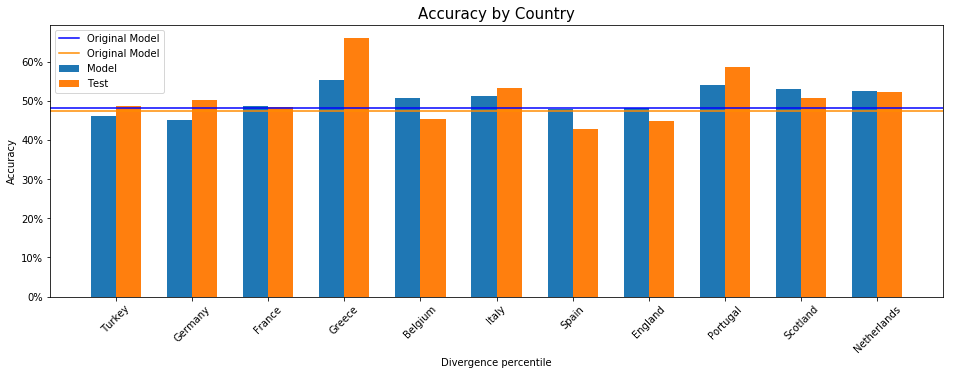

In [59]:
# Accuracy by divergence range

fig, ax = plt.subplots(figsize=[16,5])

#index = np.arange(len(labelList))
index = np.arange(len(labelList))

bar_width = 0.33
plt.bar(index - bar_width/2, modelList, bar_width, label="Model")
plt.bar(index + bar_width/2, predictList, bar_width, label="Test")
plt.axhline(y=0.4816, color='blue', label='Original Model')
plt.axhline(y=0.4744, color='darkorange', label='Original Model')

ax.set_title("Accuracy by Country", fontsize="15")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Divergence percentile")
#ax.set_ylim(0, 1)
ax.set_xticks(index)
vals = ax.get_yticks()
ax.set_yticklabels(["{:,.0%}".format(x) for x in vals])
ax.set_xticklabels(countryList, rotation=45)

ax.legend()
#ax.set_xticklabels()
plt.show()

Conclusion: Only a few country (greece, portugal, italy, ...) has a higher accuracy take a partial dataset partitining by country